# Portfolio Task 2: Forecasting UK Covid-19 cases

## Introduction
This analysis focuses on predicting COVID-19 case trends in the UK by examining daily reported cases and deaths from January 1 to June 14, 2020, helping to identify patterns and potential future outbreaks.

## Main Findings:

- The number of Covid-19 cases peaked in `April 2020` and began to gradually decline afterward.
- Between `1 June` and `14 June 2020`, the daily new cases fluctuated around `1,600`.
- From `15 to 21 June 2020`, the number of new cases is forecasted to remain steady at approximately `1,600` per day.

## Tasks

Predict the number of cases (as a time series variable) for the next `7 days`, `15–21 June 2020`.

[1. Is the time series stationary? Explain it by both using the plot of time series data as well as the applying the autocorrelation method. Does this time series require differencing? Why?](#2_1)

[2. Select the values of ARIMA model parameters explaining why selecting the suggested values. Estimate the suggested ARIMA model and explain why it is the best model fitting the data. Then calculate the forecasts of the number of Covid-19 cases for the next seven days. How good is the estimation? Is it a good prediction? Why? Look at the parameter of the model. Estimate a more parsimonious model to describe number of cases? What model?](#2_2)

## The Project Directory:

The Portfolio 2 Project files can be found in the Github Repository: [github.com/lamtong/portfolio2_covid_19_uk](https://github.com/lamtong/portfolio2_covid_19_uk)

## I. Data Pre-processing

In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error
import sys
import os

sys.path.append(os.path.abspath(".."))
from shared_files.custom_plots import plot_props  # Import the customise plot module

import warnings
# Ignore FutureWarnings
warnings.filterwarnings("ignore", 
                        category = FutureWarning)  

# Ignore SettingWithCopyWarning
warnings.simplefilter("ignore", 
                      category = pd.errors.SettingWithCopyWarning) 

In [3]:
# import the dataset
df_org = pd.read_excel('Covid19_uk.xlsx')

### 1. Nulls and Duplicates handling
**Missing values:**

In [4]:
# Number of missing data
print(f'Nulls in Base Data:\n{df_org.isna().sum()}\n')

Nulls in Base Data:
dateRep                    0
day                        0
month                      0
year                       0
cases                      0
deaths                     0
countriesAndTerritories    0
geoId                      0
countryterritoryCode       0
popData2018                0
continentExp               0
dtype: int64



**Duplicated Values:**

In [5]:
# Duplicates checking
print(f'Duplicated in Base Data: {df_org.duplicated().sum()}')

Duplicated in Base Data: 0


### 2. Correcting Data


**Correct the record with a negative number of cases:**

In [6]:
# show dates with negative number of cases
df_org[df_org['cases'] < 0]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
141,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991,Europe


In [7]:
# correct
df_org.loc[df_org['cases'] < 0 , 'cases'] = abs(df_org.loc[df_org['cases'] < 0 , 'cases'])

**Indices as Timestamp:**

In [8]:
# Casting 'Month' to datetime format
df_org['date'] = pd.to_datetime(df_org['dateRep'], format='%Y-%m')
df_org.set_index('date', inplace=True) 

## II. Portfolio 2 Tasks

### The Number of UK Covid cases:

From `1 January to 27 February 2020`, there were either no new cases or only one or two. As this period is insignificant, it is considered non-informative and should be excluded from the ARIMA model.

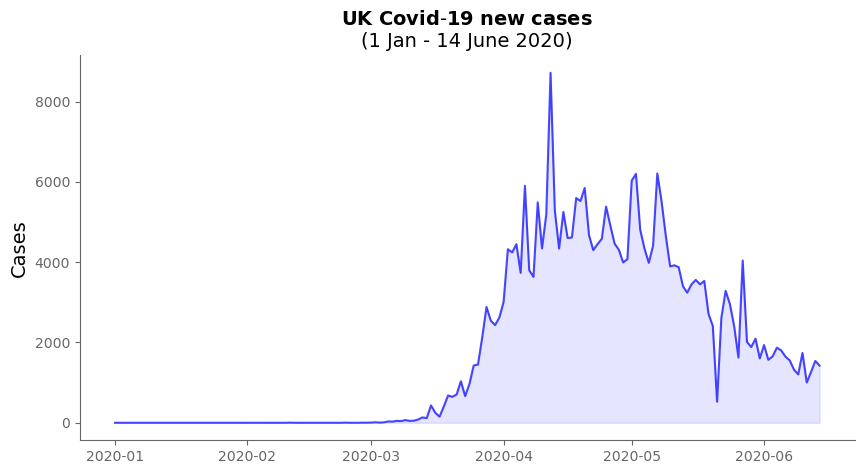

In [9]:
# Plot the original time series data
plt.figure(figsize=(10, 5))
sns.lineplot(data  = df_org,
             x     = df_org['dateRep'],
             y     = df_org['cases'],
             color = 'blue',
             alpha = 0.7) 

# Fill under the curve
plt.fill_between(df_org['dateRep'],
                 df_org['cases'],
                 color = 'blue',
                 alpha =.1)  

# Show the plot
plot_props(title    = r'$\bf{UK\ Covid\text{-}19\ new\ cases}$' '\n(1 Jan - 14 June 2020)',
           y_label  = 'Cases', 
           x_y_size = 14,
           legend   = False)

# dropping the non-informative period from 2020-01-01 to 2020-02-27
df = df_org[df_org['dateRep'] > '2020-02-27']

<a name="2_1"></a>
### 1. Is the time series stationary? Explain it by both using the plot of time series data as well as the applying the autocorrelation method. Does this time series require differencing? Why?

#### Stationarity Intepretation:

**Using `Augmented Dickey-Fuller` to check for stationarity:**

In [10]:
def adf_intepret(series):
    '''
    This function check for stationarity of a series using Augmented Dickey-Fuller method
    
    Arguments:
        series -- the checked series
    '''
    
    adf = adfuller(series)
    if adf[1] < 0.05:
        print(f"p = {adf[1]} < 0.05: The series is Stationary")
    else:
        print(f"p = {adf[1]} > 0.05: The series is Non-Stationary")
        
# Augmented Dickey-Fuller test on the original series
adf_intepret(df['cases'])

p = 0.25652532110308573 > 0.05: The series is Non-Stationary


**Visual intepretation to check for Stationarity:**

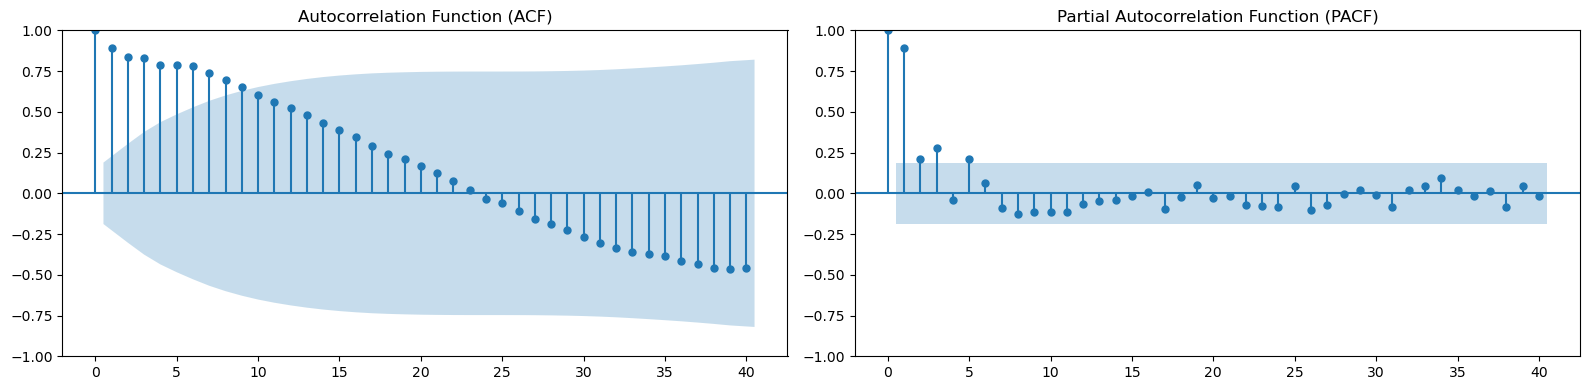

In [11]:
# Plot ACF and PACF for the original series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(df['cases'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['cases'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

**Stationarity Conclusions:**

- The gradual decline of `ACF` values indicates `non-stationary` series.
- The first partial autocorrelation is very dominant and close to `1`, also indicating `non-stationary`.
- Lastly, the trend in the Original time series plot clearly indicates `non-stationary` in the series.

#### Differencing:

**Since the Original Series is `Non-Stationary`, we difference the data:**

ARIMA Model assume stationarity from the series. Differencing removes trends and seasonality, stabilising the mean and variance, which improves forecasting accuracy and model reliability.

In [12]:
# differencing
df['cases_diff'] = df['cases'].diff()

# ADF on differencings
adf_intepret(df['cases_diff'].dropna())

p = 2.2708772221666892e-12 < 0.05: The series is Stationary


<a name="2_2"></a>

### 2. Select the values of ARIMA model parameters explaining why selecting the suggested values

#### 2.1 Estimate the suggested ARIMA model and explain why it is the best model fitting the data. 

**Finding the ARIMA terms:**

ARIMA stands for `Autoregressive Integrated Moving Average Model`. The ARIMA model combines these components into a unified framework: 

**AR(p)**- Autoregressive model: Models the dependency of the current observation on past observations (lags), with `p` representing the number of lags. The PACF cutting off at lag `p` indicates the model order.

**I(d)** - Integration: Used to make a time series stationary by differencing it `d` times, where differencing subtracts observations at time t-1 from t.

**MA(q)** - Moving Average model: Models the relationship between an observation and past error terms, with `q` indicating how many past errors are considered. The ACF cutting off at lag `q` suggests the model order.

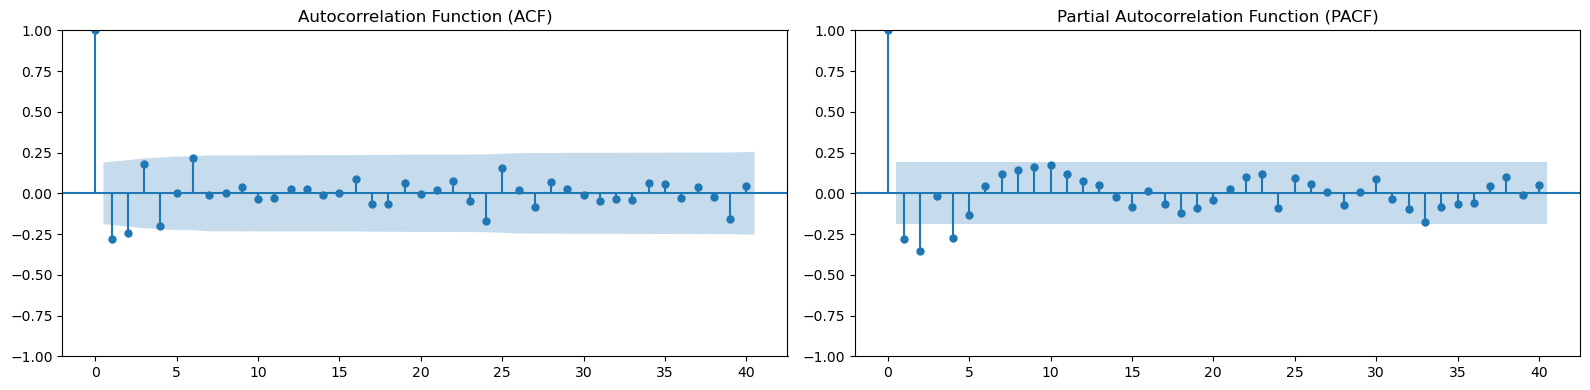

In [14]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(df['cases_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['cases_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

**Conclusions:**
- Based on PACF Plot, the number of PACF cuts off is `p = 4`
- The number of differencing to achieve stationarity is `d = 1`
- Based on ACF Plot, the number of lags where ACF cuts off is `q = 2`

#### 2.2. Calculate the forecasts of the number of Covid-19 cases for the next seven days. 

**A training workflow for the ARIMA Model:**

With `p = 4`, `d = 1`, and `q = 2`, the ARIMA Model:

In [15]:
# Definet the training set
y_train = df['cases']

# Fit ARIMA model
model = ARIMA(y_train, order=(4, 1, 2), freq = 'D') # (p, d, q) = (4, 1, 2)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

c:\Users\blueb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  108
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -860.207
Date:                Wed, 19 Mar 2025   AIC                           1734.415
Time:                        21:35:51   BIC                           1753.125
Sample:                    02-28-2020   HQIC                          1742.000
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4873      0.384      1.271      0.204      -0.264       1.239
ar.L2         -0.5938      0.197     -3.009      0.003      -0.981      -0.207
ar.L3         -0.0039      0.121     -0.032      0.9

**Forecasting the Covid-19 cases for the next `7 days`:**

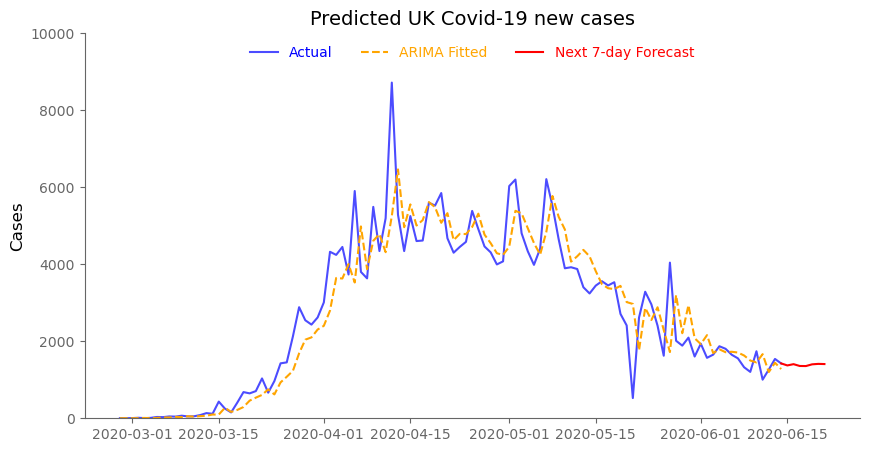

In [16]:
# Get fitted values (in-sample predictions)
df["fitted"] = model_fit.fittedvalues

# 7-day forecast using the fitted ARIMA Model
forecast_steps = 7 # predict the next 7 days
forecast = model_fit.forecast(steps = forecast_steps)
forecast = forecast.to_frame()
forecast = forecast.rename(columns = {'predicted_mean' : 'cases'})

# join the original dataset and the next 7 days forecast set
df_arima_7 = pd.concat([df , forecast]).sort_index()

def plot_pred(data, actual, fitted):
    '''
    Plot the ARIMA forecasted series against the actual value
    
    Arguments:
        data   -- the complete dataset
        actual -- name of the actual field
        fitted -- name of the ARIMA fitted field
    '''
    
    # Plot actual vs fitted values
    plt.figure(figsize=(10, 5))

    # the actual data lineplot
    plt.plot(data.index[:len(data) - 7], 
            data[actual].iloc[:len(data) - 7], 
            label = "Actual", 
            color = "blue",
            alpha = 0.7)

    # the ARIMA-fitted plot
    plt.plot(data.index, 
            data[fitted], 
            label     = "ARIMA Fitted", 
            color     = "orange", 
            linestyle = "dashed")

    # the next 7 days forecasting plot
    plt.plot(data.index[-8:],
            data[actual].iloc[-8:],
            label = 'Next 7-day Forecast',
            color = 'red')
    
    # show the plot
    plt.ylim(0, 10000)
    plot_props(title    = "Predicted UK Covid-19 new cases",
                y_label = 'Cases',
                lgn_loc = 'upper center',
                lgn_col = 3)

# visualise the series forecast        
plot_pred(df_arima_7, 'cases', 'fitted')

#### 2.3. How good is the estimation? It is a good prediction? Why?

**ARIMA Model Evaluations:**

With `p = 4`, `d = 1`, `q = 2`:

- There are `2` siginifcant AR lags (2nd and 4th) and `1` significant MA lag (1st) (with p > `0.05`). Indicating strong significance of these lags to describe the forecasted value.
- The `p-value` of `Ljung-Box (Q)` Test is `0.78` (`> 0.05`), this means residuals are not autocorrelated and good model fit in this aspect.

**Error Evaluations:**
- The Mean Absolute Error (`483.9`) indicates that, on average, the ARIMA model's predictions deviate by `484` cases per day from actual values.
- With the Average daily case of `2735` during the fitted period and the average ARIMA-fitted error of `483.9`, the Relative MAE is around `17.6%`. Given the context of the predictions, this is acceptable. However, optimising the ARIMA Model or using other appropriate forecasting method (e.g. ARIMAX) can be used for a lower error.

In [17]:
# average daily case during the ARIMA-fitted period
print(f'Average daily cases: {df['cases'].mean()}')

Average daily cases: 2735.296296296296


In [18]:
mae = np.mean(abs(model_fit.resid)) # MAE on the fitted historical data  
mse = np.mean(abs(model_fit.resid) ** 2) #MSE on the fitted historical data  

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 483.87904179538333
Mean Squared Error (MSE): 553943.1548347407


**Residual ACF and Residual PACF Evaluations:**

The ACF/PACF of Residuals show no significant lags, meaning the model is well-fitted:
- No significant spikes in ACF: Model fits well; residuals are uncorrelated.
- No significant spikes in PACF: Residuals are independent, meaning ARIMA captured all dependencies.

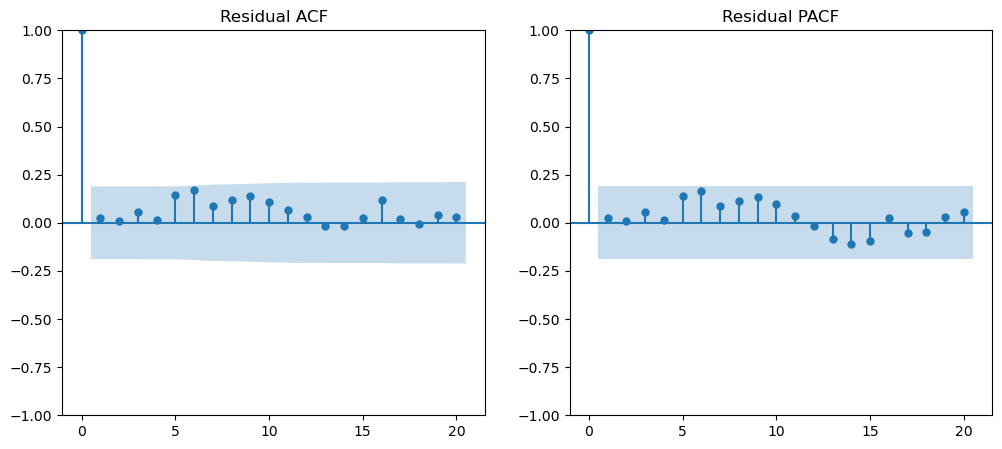

In [19]:
# Get residuals
residuals = model_fit.resid

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(residuals, ax=axes[0], lags=20)
axes[0].set_title("Residual ACF")

plot_pacf(residuals, ax=axes[1], lags=20)
axes[1].set_title("Residual PACF")

plt.show()

**Prediction Evaluations:**

The prediction follows the trend observed in `June 2020` - where daily cases fluctuated below `2000 cases` daily, but with little variation. This suggests that the ARIMA Model captures the general pattern accurately. While it may not fully account for smaller fluctuations, this level of stability can be acceptable if the goal is to predict a general trend rather than a exact daily cases.

#### 2.4. Look at the parameter of the model. Estimate a more parsimonious model to describe number of cases. What model?

**The Parsimonious Model:**

After experimenting  different p, d, and q terms for the ARIMA model, the parsimonious model with ARIMA terms (`p`, `d`, `q`) of `4`, `1`, and `0`:

- There are `3` siginifcant AR lags (1st, 2nd, and 4th) (with `p > 0.05`). Indicating strong significance of these lags to describe the forecasted value.
- The `p-value` of `Ljung-Box (Q)` Test is `0.68` (>` 0.05`), this means residuals are not autocorrelated and good model fit in this aspect, but not as good as the intial model with `q = 2`.
- The parsimonious Model shows higher errors (`MAE` = `489.2`), resulting in a slightly less well-fitted regarding this matter.
- The parsimonious model has slightly lower `AIC` and `BIC` values compared to the first model, indicating that it provides a better fit with less complexity:

| Model            | AIC      | BIC      |
|------------------|----------|----------|
| First Model      | 1734.415 | 1753.125 |
| Parsimonious Model | 1733.763 | 1747.127 |


- Therefore, the parsimonious model is preferred as it balances model accuracy and simplicity more effectively.


In [20]:
# Fit the new ARIMA model
model_new = ARIMA(y_train, 
                  order=(4, 1, 0),
                  freq = 'D') 
model_fit_new = model_new.fit()

# Print the model summary
print(model_fit_new.summary())

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  108
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -861.882
Date:                Wed, 19 Mar 2025   AIC                           1733.763
Time:                        21:35:51   BIC                           1747.127
Sample:                    02-28-2020   HQIC                          1739.181
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3844      0.068     -5.641      0.000      -0.518      -0.251
ar.L2         -0.4480      0.105     -4.278      0.000      -0.653      -0.243
ar.L3         -0.1162      0.102     -1.142      0.2

c:\Users\blueb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


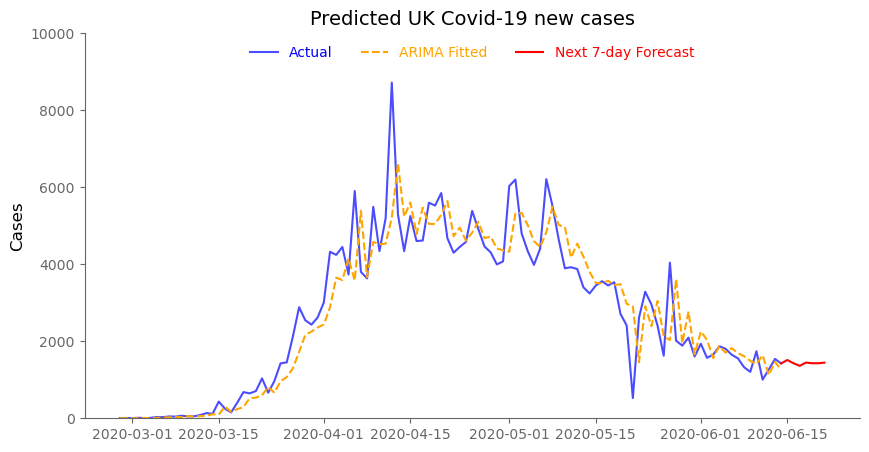

In [21]:
# Get fitted values (in-sample predictions)
df["fitted_new"] = model_fit_new.fittedvalues

# Forecast
forecast_steps = 7 # predict the next 7 days
forecast_new = model_fit_new.forecast(steps=forecast_steps)
forecast_new = forecast_new.to_frame()
forecast_new = forecast_new.rename(columns = {'predicted_mean' : 'cases'})

# merge original dataset and forecast one
df_arima_7_new = pd.concat([df , forecast_new]).sort_index()

# plot the most parsimonious model results
plot_pred(df_arima_7_new, 'cases', 'fitted_new')

In [22]:
mae_new = np.mean(abs(model_fit_new.resid)) # MAE on the fitted historical data  
mse_new = np.mean(abs(model_fit_new.resid) ** 2) #MSE on the fitted historical data  

print("Mean Absolute Error (MAE):", mae_new)
print("Mean Squared Error (MSE):", mse_new)

Mean Absolute Error (MAE): 489.18603452002526
Mean Squared Error (MSE): 572166.6713711522


#### 2.5. The `7-day` forecasted Covid-19 Cases in the UK from `15 to 21 June 2020`:
The forecast use the Parsimonious ARIMA Model, with ARIMA terms of `p = 4`, `d = 1`, and `q = 0`.

**Daily Cases:**

The number of cases is predicted to be remained relatively stable between `1356` and `1413` from `June 15-21`, with only minor fluctuations.

In [23]:
# show the predictions of the best ARIMA model
forecast['cases'] = forecast['cases'].round().astype('int64')
forecast

,cases
2020-06-15,1373
2020-06-16,1406
2020-06-17,1359
2020-06-18,1356
2020-06-19,1401
2020-06-20,1413
2020-06-21,1408


**The Forecasting Graph:**

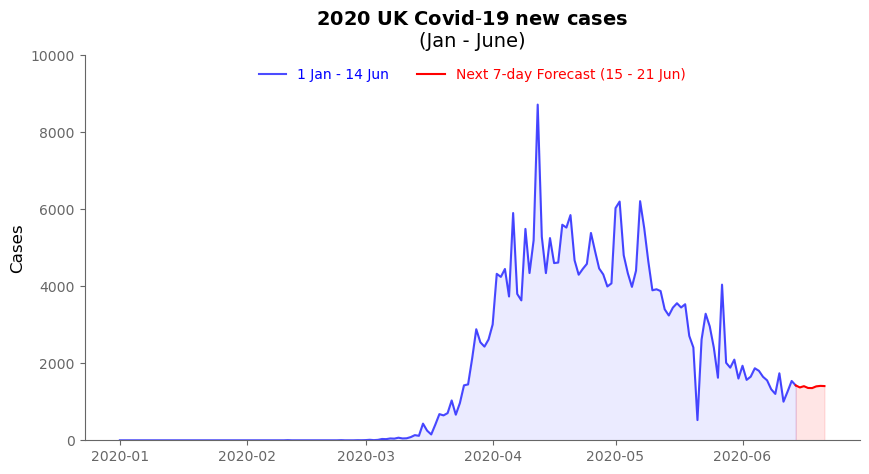

In [24]:
# Plot the Final predictions
plt.figure(figsize=(10, 5))

# the historical data lineplot
plt.plot(df_org.index, 
         df_org['cases'], 
         label = "1 Jan - 14 Jun", 
         color = "blue",
         alpha = 0.7)

# the next 7 days forecasting plot
plt.plot(df_arima_7.index[-8:],
         df_arima_7['cases'].iloc[-8:],
         label = 'Next 7-day Forecast (15 - 21 Jun)',
         color = 'red')

# Fill under the curve
plt.fill_between(df_org.index,
                 df_org['cases'], 
                 color = 'blue',
                 alpha =.08)  

plt.fill_between(df_arima_7.index[-8:],
                 df_arima_7['cases'].iloc[-8:],
                 color = 'red',
                 alpha =.1)  

# show the plot
plt.ylim(0, 10000)
plot_props(title    = r'$\bf{2020\ UK\ Covid\text{-}19\ new\ cases}$' '\n(Jan - June)',
            y_label = 'Cases',
            lgn_loc = 'upper center',
            lgn_col = 2)